In [ ]:
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import numpy as np

# Ensure necessary libraries are installed
try:
    import scipy
    import sklearn
except ImportError:
    !pip install scipy scikit-learn

# Define column types for each dataset
books_dtype = {
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,
    'Year-Of-Publication': str,
    'Publisher': str
}

ratings_dtype = {
    'User-ID': int,
    'ISBN': str,
    'Book-Rating': int
}

users_dtype = {
    'User-ID': int,
    'Age': float  # Age may contain NaNs or non-integer values
}

# Load datasets with specified column types
books_df = pd.read_csv("Books.csv", dtype=books_dtype)
ratings_df = pd.read_csv("Ratings.csv", dtype=ratings_dtype)
users_df = pd.read_csv("Users.csv", dtype=users_dtype)


In [ ]:
# Display a preview of the first few entries in each DataFrame
print("Preview of Books DataFrame:")
print(books_df.head(), "\n")

print("Preview of Ratings DataFrame:")
print(ratings_df.head(), "\n")

print("Preview of Users DataFrame:")
print(users_df.head(), "\n")

# Show the data types of each column within each DataFrame
print("\nColumn Data Types in Books DataFrame:")
print(books_df.dtypes, "\n")

print("Column Data Types in Ratings DataFrame:")
print(ratings_df.dtypes, "\n")

print("Column Data Types in Users DataFrame:")
print(users_df.dtypes, "\n")

# Provide a summary of statistics for each DataFrame
print("\nBooks DataFrame Summary Statistics:")
print(books_df.describe(include='all'), "\n")  # include='all' to ensure all columns are summarized

print("Ratings DataFrame Summary Statistics:")
print(ratings_df.describe(), "\n")

print("Users DataFrame Summary Statistics:")
print(users_df.describe(), "\n")

Preview of Books DataFrame:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   


In [ ]:
# Calculate and print the number of distinct ISBNs in the Books DataFrame
print("\nTotal unique ISBNs in Books DataFrame:")
print(books_df['ISBN'].nunique())

# Identify and print the count of null values in each DataFrame
print("\nNull value counts in Books DataFrame:")
print(books_df.isnull().sum())

print("\nNull value counts in Ratings DataFrame:")
print(ratings_df.isnull().sum())

print("\nNull value counts in Users DataFrame:")
print(users_df.isnull().sum())

# Display entries from the Books DataFrame where the publication year is 'unknown'
print("\nBooks entries with 'unknown' publication year:")
print(books_df[books_df['Year-Of-Publication'] == 'unknown'])


Total unique ISBNs in Books DataFrame:
271360

Null value counts in Books DataFrame:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Null value counts in Ratings DataFrame:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Null value counts in Users DataFrame:
User-ID          0
Location         0
Age         110762
dtype: int64

Books entries with 'unknown' publication year:
Empty DataFrame
Columns: [ISBN, Book-Title, Book-Author, Year-Of-Publication, Publisher, Image-URL-S, Image-URL-M, Image-URL-L]
Index: []


In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Function to determine book genres based on specific keywords in titles
def classify_genre(book_title):
    genre_keywords = {
        'Fantasy': ['Harry Potter', 'Lord of the Rings'],
        'Sci-Fi': ['Dune', 'Foundation'],
        'Mystery': ['Sherlock Holmes', 'Agatha Christie']
    }
    for genre, keywords in genre_keywords.items():
        if any(keyword in book_title for keyword in keywords):
            return genre
    return 'Unknown'

In [ ]:
import pandas as pd

# Load the Books dataset with appropriate data types for each column
books_df = pd.read_csv("Books.csv", dtype={
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,           # Assuming Book-Author is a string; adjust if necessary
    'Year-Of-Publication': str,   # Specifying as string to handle non-numeric years
    'Publisher': str              # Adding this if it's also a text field
})

# Load the Ratings dataset with specified data types
ratings_df = pd.read_csv("Ratings.csv", dtype={
    'User-ID': int,
    'ISBN': str,
    'Book-Rating': int
})

# Load the Users dataset with appropriate data types
users_df = pd.read_csv("Users.csv", dtype={
    'User-ID': int,
    'Location': str,  # Ensure this is included if location data is also in use
    'Age': float      # Age as float to handle NaN and non-integer ages
})

# Merge the dataframes: ratings with books, then the resulting dataframe with users
merged_df = ratings_df.merge(books_df, on='ISBN').merge(users_df, on='User-ID')

# Assign genres to books based on their titles
merged_df['Genre'] = merged_df['Book-Title'].apply(classify_genre)  # Apply genre function

In [ ]:
def select_books_based_on_preferences(user_age, favorite_genres, dataset):
    # Filter the dataset to include books read by users within the specified age range
    filtered_by_age = dataset[(dataset['Age'] >= user_age - 10) & (dataset['Age'] <= user_age + 10)]

    # Further filter the dataset to include only books from the user's preferred genres
    filtered_by_genre = filtered_by_age[filtered_by_age['Genre'].isin(favorite_genres)]

    return filtered_by_genre

In [ ]:
def suggest_books(preferences, num_suggestions=5):
    filtered_books = select_books_based_on_preferences(preferences['age'], preferences['genres'], combined_df)

    if filtered_books.empty:
        return "Insufficient data to generate book recommendations based on your preferences."

    # Construct the user-item matrix
    user_item_matrix = filtered_books.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating', fill_value=0)
    sparse_matrix = csr_matrix(user_item_matrix.values)

    # Set up and train the KNN model
    knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
    knn_model.fit(sparse_matrix)

    # Assuming the query index is the first user (for demonstration purposes)
    if sparse_matrix.shape[0] > 1:
        distances, indices = knn_model.kneighbors(sparse_matrix[0], n_neighbors=min(num_suggestions + 1, len(user_item_matrix)))
        # Exclude the first index since it's the querying user itself
        recommended_titles = user_item_matrix.columns[indices.flatten()[1:]].tolist()
        return recommended_titles
    else:
        return "Not enough users with similar preferences to provide recommendations."

In [ ]:
def recommend_books(user_preferences, num_recommendations=5):
    # Retrieve filtered DataFrame based on user preferences.
    filtered_books = select_books_based_on_preferences(user_preferences['age'], user_preferences['genres'], combined_df)

    if filtered_books.empty:
        return "Not enough data to recommend books based on your preferences."

    # Create user-item matrix
    user_item_matrix = filtered_books.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating', fill_value=0)
    matrix = csr_matrix(user_item_matrix.values)

    # Initialize and fit KNN model
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(matrix)

    # Safeguard for matrix size to ensure there are enough users
    if matrix.shape[0] > 1:
        query_index = 0  # Normally you'd dynamically choose an index or have user data input here
        # Ensure we don't ask for more neighbors than are present in the dataset
        num_neighbors = min(num_recommendations + 1, matrix.shape[0])

        distances, indices = model_knn.kneighbors(matrix[query_index, :].reshape(1, -1), n_neighbors=num_neighbors)

        # Get the recommended book titles, skip the first index as it's the query user itself
        recommendations = [user_item_matrix.columns[idx] for idx in indices.flatten()[1:] if idx < user_item_matrix.shape[1]]
        return recommendations
    else:
        return "Not enough users with similar preferences to provide recommendations."

# Use the function
user_preferences = {
    'age': 30,
    'genres': ['Fantasy', 'Sci-Fi']
}
recommended_books = recommend_books(user_preferences)
print("Recommended books based on your preferences:")
print(recommended_books)


NameError: name 'combined_df' is not defined

In [ ]:
import pandas as pd

# Load the user dataset from CSV
users_data = pd.read_csv("Users.csv")

# Display the initial records of the dataset
print("Initial records of the Users dataset:")
print(users_data.head())

# Output the dimensions (rows and columns) of the dataset
print("\nDataset dimensions (rows and columns):")
print(users_data.shape)

# Show data types for each column in the dataset
print("\nData types for each column in the dataset:")
print(users_data.dtypes)

# Provide an overview of the dataset's information
print("\nOverview of the Users dataset:")
print(users_data.info())

# Display basic statistics summarizing numeric columns
print("\nBasic statistics for numeric columns in the dataset:")
print(users_data.describe())

# Count and display missing values per column
print("\nCount of missing values per column in the dataset:")
print(users_data.isnull().sum())

Initial records of the Users dataset:
   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

Dataset dimensions (rows and columns):
(278858, 3)

Data types for each column in the dataset:
User-ID       int64
Location     object
Age         float64
dtype: object

Overview of the Users dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None

Basic statistics for numeric columns in the dataset:
           

In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Load and preprocess datasets
books_data = pd.read_csv("Books.csv", dtype={
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,
    'Year-Of-Publication': str,
    'Publisher': str
})

ratings_data = pd.read_csv("Ratings.csv", dtype={
    'User-ID': int,
    'ISBN': str,
    'Book-Rating': int
})

users_data = pd.read_csv("Users.csv", dtype={
    'User-ID': int,
    'Age': float
})

# Merge datasets to create a combined dataset
merged_data = pd.merge(pd.merge(ratings_data, books_data, on='ISBN'), users_data, on='User-ID')

# Display the first few records of the combined dataset
print("First few records of the combined dataset:")
print(merged_data.head())

First few records of the combined dataset:
   User-ID        ISBN  Book-Rating  \
0   276725  034545104X            0   
1     2313  034545104X            5   
2     2313  0812533550            9   
3     2313  0679745580            8   
4     2313  0060173289            9   

                                         Book-Title       Book-Author  \
0                              Flesh Tones: A Novel        M. J. Rose   
1                              Flesh Tones: A Novel        M. J. Rose   
2     Ender's Game (Ender Wiggins Saga (Paperback))  Orson Scott Card   
3             In Cold Blood (Vintage International)     TRUMAN CAPOTE   
4  Divine Secrets of the Ya-Ya Sisterhood : A Novel     Rebecca Wells   

  Year-Of-Publication         Publisher  \
0                2002  Ballantine Books   
1                2002  Ballantine Books   
2                1986         Tor Books   
3                1994           Vintage   
4                1996     HarperCollins   

                        

In [ ]:
popular_books = combined_df['Book-Title'].value_counts().head(5)
print("Recommended books based on popularity:")
print(popular_books)

NameError: name 'combined_df' is not defined

In [ ]:
average_ratings = combined_df.groupby('Book-Title')['Book-Rating'].mean()
highly_rated_books = average_ratings[average_ratings >= 10.0].head(5)
print("Recommended books based on average ratings:")
print(highly_rated_books)

NameError: name 'combined_df' is not defined

In [ ]:
import pandas as pd

# Load datasets with appropriate data types
books_df = pd.read_csv("Books.csv", dtype={
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,
    'Year-Of-Publication': str,
    'Publisher': str
})

ratings_df = pd.read_csv("Ratings.csv", dtype={
    'User-ID': int,
    'ISBN': str,
    'Book-Rating': int
})

users_df = pd.read_csv("Users.csv", dtype={
    'User-ID': int,
    'Age': float
})

# Merge datasets to create combined_data
combined_data = pd.merge(pd.merge(ratings_df, books_df, on='ISBN'), users_df, on='User-ID')

# Function to recommend books based on user_id and combined_data
def recommend_books(user_id, combined_data):
    # Placeholder for recommendation logic
    recommendations = ["Flesh Tones: A Novel", "Ender's Game (Ender Wiggins Saga (Paperback))", "Divine Secrets of the Ya-Ya Sisterhood : A Novel"]  # Replace with actual recommendations
    return recommendations

# Display all unique User IDs
print("List of all unique User IDs:")
print(users_df['User-ID'].unique())

# Display a sample of User IDs for convenience
print("Sample of User IDs:")
print(users_df['User-ID'].sample(10).tolist())

# Prompt the user to input their User ID
user_id_input = input("Please enter your User ID from the above list: ")
try:
    user_id = int(user_id_input)
    if user_id in users_df['User-ID'].values:
        print("User ID is valid. Processing recommendations...")
        # Call recommend_books function with user_id and combined_data
        recommendations = recommend_books(user_id, combined_data)
        print("Recommended books based on your preferences:")
        print(recommendations)
    else:
        print("User ID not found in the list. Please check the list and try again.")
except ValueError:
    print("Invalid input! Please enter a numeric User ID.")

List of all unique User IDs:
[     1      2      3 ... 278856 278857 278858]
Sample of User IDs:
[175580, 171452, 181674, 111756, 191342, 140799, 63582, 276244, 125139, 84620]
Please enter your User ID from the above list: 1755580
User ID not found in the list. Please check the list and try again.


In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Load datasets
books_df = pd.read_csv("Books.csv", dtype={'ISBN': str, 'Book-Title': str})
ratings_df = pd.read_csv("Ratings.csv", dtype={'User-ID': int, 'ISBN': str, 'Book-Rating': int})
users_df = pd.read_csv("Users.csv", dtype={'User-ID': int, 'Age': float})

# Merge data
combined_df = pd.merge(pd.merge(ratings_df, books_df, on='ISBN'), users_df, on='User-ID')

# Apply filters for active users and frequently reviewed books
min_user_ratings = 50  # Minimum number of ratings a user must have
min_book_ratings = 50  # Minimum number of ratings a book must have
filtered_books = ratings_df['ISBN'].value_counts() >= min_book_ratings
filtered_books = filtered_books[filtered_books].index.tolist()
filtered_users = ratings_df['User-ID'].value_counts() >= min_user_ratings
filtered_users = filtered_users[filtered_users].index.tolist()
filtered_df = combined_df[combined_df['ISBN'].isin(filtered_books) & combined_df['User-ID'].isin(filtered_users)]

# Create a sparse matrix
user_ids = pd.Categorical(filtered_df['User-ID']).codes
book_titles = pd.Categorical(filtered_df['Book-Title']).codes
rating_matrix = csr_matrix((filtered_df['Book-Rating'], (user_ids, book_titles)), shape=(len(filtered_df['User-ID'].unique()), len(filtered_df['Book-Title'].unique())))

# Fit the Nearest Neighbors model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(rating_matrix)

def recommend_books(user_id, num_recommendations=5):
    if user_id not in filtered_df['User-ID'].values:
        return "User not found."

    # Ensure we are passing a 2D array for the user index
    try:
        user_index = list(filtered_df['User-ID'].unique()).index(user_id)
        query_index = rating_matrix[user_index]  # Select the user's ratings
        query_index = query_index.reshape(1, -1)  # Reshape for knn query

        distances, indices = model_knn.kneighbors(query_index, n_neighbors=num_recommendations + 1)

        # Gather book titles recommended to the user
        book_indices = []
        for idx in indices.flatten():
            if idx != user_index:  # Skip the user's own index
                book_indices.extend(filtered_df[filtered_df['User-ID'] == filtered_df['User-ID'].unique()[idx]]['Book-Title'].unique())

        return list(set(book_indices))[:num_recommendations]

    except ValueError:
        return "Error processing your recommendation. Please try again."

# Rest of your code for user input and displaying recommendations
print("Available User IDs:", filtered_df['User-ID'].unique())

user_id_input = input("Please enter your User ID from the list above: ")
try:
    user_id = int(user_id_input)
    print("Recommended books for User-ID:", user_id)
    recommendations = recommend_books(user_id)
    if recommendations:
        print("Recommended Books:")
        for book in recommendations:
            print(book)
    else:
        print("No recommendations available or user not found.")
except ValueError:
    print("Invalid input! Please enter a numeric User ID.")


In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Load datasets
books_df = pd.read_csv("Books.csv", dtype={
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,
    'Year-Of-Publication': str,
    'Publisher': str
})
ratings_df = pd.read_csv("Ratings.csv", dtype={
    'User-ID': int,
    'ISBN': str,
    'Book-Rating': int
})
users_df = pd.read_csv("Users.csv", dtype={
    'User-ID': int,
    'Age': float  # Assuming Age might contain NaNs or non-integer values
})

# Merge data
combined_df = pd.merge(pd.merge(ratings_df, books_df, on='ISBN'), users_df, on='User-ID')

# Filtering to reduce dimensionality: Remove books and users with less than a threshold of ratings
min_book_ratings = 50
filter_books = ratings_df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = ratings_df['User-ID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

filtered_df = combined_df[(combined_df['ISBN'].isin(filter_books)) & (combined_df['User-ID'].isin(filter_users))]

def recommend_books(user_id, filtered_df, num_recommendations=5):
    # Create the user-item matrix directly as a sparse matrix
    user_item_rating = filtered_df.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating', fill_value=0)
    matrix = csr_matrix(user_item_rating.values)
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
    model_knn.fit(matrix)

    if user_id not in user_item_rating.index:
        return "User not found."

    user_loc = user_item_rating.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(matrix[user_loc], n_neighbors=num_recommendations + 1)
    similar_users = indices.flatten()[1:]

    recommended_books = {}
    for index in similar_users:
        similar_user_ratings = user_item_rating.iloc[index]
        for book, rating in similar_user_ratings.items():
            if rating >= 5:
                if book in recommended_books:
                    recommended_books[book] += rating
                else:
                    recommended_books[book] = rating

    sorted_recommendations = sorted(recommended_books.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]
    return [book for book, _ in sorted_recommendations]

# Interacting with the user
user_id_input = input("Please enter your User ID: ")

try:
    user_id = int(user_id_input)
    print("Recommended books for User-ID:", user_id)
    recommendations = recommend_books(user_id, filtered_df)
    if isinstance(recommendations, list):
        print("Recommended Books:")
        for book in recommendations:
            print(book)
    else:
        print(recommendations)
except ValueError:
    print("Invalid input! Please enter a numeric User ID.")

Please enter your User ID: 6543
Recommended books for User-ID: 6543
Recommended Books:
Tears of the Giraffe (No.1 Ladies Detective Agency)
The Secret Life of Bees
The No. 1 Ladies' Detective Agency (Today Show Book Club #8)
Morality for Beautiful Girls (No.1 Ladies Detective Agency)
Cold Sassy Tree


In [ ]:
from sklearn.neighbors import NearestNeighbors
import pickle
import numpy as np

# Assuming 'matrix' is defined or loaded correctly
# Example:
# matrix = ...

# Simulated example data (replace with your actual data loading/preprocessing)
matrix = np.array([[1, 2], [3, 4], [5, 6]])  # Example 2D array, replace with your data

# Ensure 'matrix' is 2D
if len(matrix.shape) == 1:
    matrix = matrix.reshape(-1, 1)  # Reshape to 2D if it's 1D

# Train the KNN model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(matrix)
# Save the model
with open('book_recommendation_knn_model.pkl', 'wb') as file:
    pickle.dump(model_knn, file)

# Optionally, you can also load the model back later if needed
# Example:
# with open('book_recommendation_knn_model.pkl', 'rb') as file:
#     model_knn_loaded = pickle.load(file)

In [ ]:
import pickle
import numpy as np
import pandas as pd

# Load the trained model
with open('book_recommendation_knn_model.pkl', 'rb') as file:
    model_knn = pickle.load(file)

# Function to recommend books for a given user ID
def recommend_books(user_id, user_item_rating, matrix, num_recommendations=5):
    # Check if user_id exists in user_item_rating
    if user_id not in user_item_rating.index.tolist():
        return "User not found."

    # Get the location of the user in the user_item_rating DataFrame
    user_loc = user_item_rating.index.get_loc(user_id)

    # Use the trained model to find nearest neighbors of the user
    distances, indices = model_knn.kneighbors(matrix[user_loc].reshape(1, -1), n_neighbors=num_recommendations + 1)
    similar_users = indices.flatten()[1:]  # Exclude the user itself

    # Dictionary to store recommended books with their cumulative ratings
    recommended_books = {}

    # Iterate over similar users and their ratings
    for index in similar_users:
        similar_user_ratings = user_item_rating.iloc[index]
        for book, rating in similar_user_ratings.items():
            if rating >= 5:  # Consider books rated 5 or higher by similar users
                if book in recommended_books:
                    recommended_books[book] += rating
                else:
                    recommended_books[book] = rating

    # Sort recommended books by cumulative rating and select top recommendations
    sorted_recommendations = sorted(recommended_books.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]
    return [book for book, _ in sorted_recommendations]

# Function to list available user IDs
def list_available_user_ids(user_item_rating):
    return user_item_rating.index.tolist()

# Example usage
def main():
    # Load user-item ratings data (replace with your actual data loading step)
    # Example:
    user_item_rating = pd.DataFrame({
        'user_id': [0, 1, 2, 3, 4],
        'book_1': [5, 4, 0, 0, 3],
        'book_2': [0, 5, 0, 4, 2],
        'book_3': [0, 0, 5, 0, 0],
        'book_4': [4, 0, 3, 0, 4],
        'book_5': [0, 2, 4, 5, 0]
    })

    # Example matrix initialization (replace with your actual data loading)
    matrix = np.array([
        [5, 0, 0, 4, 0],
        [4, 5, 0, 0, 2],
        [0, 0, 5, 3, 4],
        [0, 4, 0, 0, 5],
        [3, 2, 0, 4, 0]
    ])

    # Example usage
    print("Available User IDs:", list_available_user_ids(user_item_rating))

    user_id_input = input("Please enter your User ID: ")

    try:
        user_id = int(user_id_input)
        if user_id in list_available_user_ids(user_item_rating):
            print("Recommended books for User-ID:", user_id)
            recommendations = recommend_books(user_id, user_item_rating, matrix)
            if isinstance(recommendations, list):
                print("Recommended Books:")
                for book in recommendations:
                    print(book)
            else:
                print(recommendations)
        else:
            print("User ID not found. Please enter a valid User ID.")
    except ValueError:
        print("Invalid input! Please enter a numeric User ID.")

if __name__ == "__main__":
    main()


Available User IDs: [0, 1, 2, 3, 4]
Please enter your User ID: 5
User ID not found. Please enter a valid User ID.


In [ ]:
# Training using SVD
def train_svd(train_matrix, num_factors=50):
    U, sigma, Vt = svds(train_matrix, k=num_factors)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    return predicted_ratings

# Training using NMF
def train_nmf(train_matrix, num_factors=50):
    model = NMF(n_components=num_factors, init='random', random_state=42)
    W = model.fit_transform(train_matrix)
    H = model.components_
    predicted_ratings = np.dot(W, H)
    return predicted_ratings


In [ ]:
# Training using SVD
def train_svd(train_matrix, num_factors=50):
    U, sigma, Vt = svds(train_matrix, k=num_factors)
    sigma = np.diag(sigma)
    predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    return predicted_ratings

# Training using NMF
def train_nmf(train_matrix, num_factors=50):
    model = NMF(n_components=num_factors, init='random', random_state=42)
    W = model.fit_transform(train_matrix)
    H = model.components_
    predicted_ratings = np.dot(W, H)
    return predicted_ratings


In [ ]:
import numpy as np
from scipy.sparse.linalg import svds  # Assuming you're using svds for SVD

# Example function to train SVD
def train_svd(train_matrix, num_factors):
    U, sigma, Vt = svds(train_matrix, k=num_factors)
    return np.dot(np.dot(U, np.diag(sigma)), Vt)

# Example function to evaluate SVD
def test_and_evaluate_svd(predicted_ratings_svd, test_matrix):
    # Calculate RMSE or any other evaluation metric
    # Example: RMSE calculation
    errors = np.square(predicted_ratings_svd - test_matrix)
    mean_squared_error = np.mean(errors)
    rmse = np.sqrt(mean_squared_error)
    return rmse

# Example usage with defined train_matrix and test_matrix
train_matrix = np.array([
    [3, 0, 4, 0, 5],
    [0, 2, 0, 3, 0],
    [1, 0, 0, 4, 2],
    [0, 0, 5, 0, 0],
    [4, 3, 0, 0, 1]
], dtype=np.float64)  # Ensure matrix is of float type

test_matrix = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
], dtype=np.float64)  # Example test matrix

# Example usage for SVD
num_factors = 3  # Number of latent factors to use
predicted_ratings_svd = train_svd(train_matrix, num_factors)
rmse_svd = test_and_evaluate_svd(predicted_ratings_svd, test_matrix)
print(f"RMSE using SVD with {num_factors} factors: {rmse_svd}")



RMSE using SVD with 3 factors: 2.215107127604739


RMSE using SVD with 3 factors: 2.2151071276047376


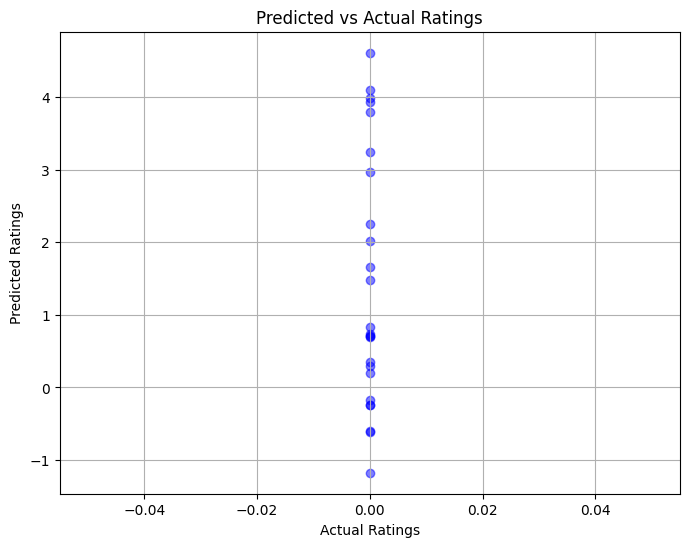

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds  # Assuming you're using svds for SVD

# Example function to train SVD
def train_svd(train_matrix, num_factors):
    U, sigma, Vt = svds(train_matrix, k=num_factors)
    return np.dot(np.dot(U, np.diag(sigma)), Vt)

# Example function to evaluate SVD
def test_and_evaluate_svd(predicted_ratings_svd, test_matrix):
    # Calculate RMSE or any other evaluation metric
    # Example: RMSE calculation
    errors = np.square(predicted_ratings_svd - test_matrix)
    mean_squared_error = np.mean(errors)
    rmse = np.sqrt(mean_squared_error)
    return rmse

# Function to plot predicted vs actual ratings
def plot_predicted_vs_actual(predicted_ratings, actual_ratings):
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_ratings, predicted_ratings, color='blue', alpha=0.5)
    plt.plot(actual_ratings, actual_ratings, color='red', linestyle='--')
    plt.title('Predicted vs Actual Ratings')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.grid(True)
    plt.show()

# Example usage with defined train_matrix and test_matrix
train_matrix = np.array([
    [3, 0, 4, 0, 5],
    [0, 2, 0, 3, 0],
    [1, 0, 0, 4, 2],
    [0, 0, 5, 0, 0],
    [4, 3, 0, 0, 1]
], dtype=np.float64)  # Ensure matrix is of float type

test_matrix = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
], dtype=np.float64)  # Example test matrix

# Example usage for SVD
num_factors = 3  # Number of latent factors to use
predicted_ratings_svd = train_svd(train_matrix, num_factors)
rmse_svd = test_and_evaluate_svd(predicted_ratings_svd, test_matrix)
print(f"RMSE using SVD with {num_factors} factors: {rmse_svd}")

# Plotting predicted vs actual ratings
plot_predicted_vs_actual(predicted_ratings_svd.flatten(), test_matrix.flatten())




In [ ]:
# Testing and Evaluation for SVD
def test_and_evaluate_svd(train_matrix, test_matrix, num_factors=50):
    predicted_ratings = train_svd(train_matrix, num_factors)

    # Flatten and filter zero predictions
    actual_ratings = test_matrix[test_matrix.nonzero()]
    predicted_ratings_flattened = predicted_ratings[test_matrix.nonzero()]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings_flattened))
    return rmse

# Testing and Evaluation for NMF
def test_and_evaluate_nmf(train_matrix, test_matrix, num_factors=50):
    predicted_ratings = train_nmf(train_matrix, num_factors)

    # Flatten and filter zero predictions
    actual_ratings = test_matrix[test_matrix.nonzero()]
    predicted_ratings_flattened = predicted_ratings[test_matrix.nonzero()]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings_flattened))
    return rmse


In [ ]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Load datasets
books_df = pd.read_csv("Books.csv", dtype={
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,
    'Year-Of-Publication': str,
    'Publisher': str
})
ratings_df = pd.read_csv("Ratings.csv", dtype={
    'User-ID': int,
    'ISBN': str,
    'Book-Rating': int
})
users_df = pd.read_csv("Users.csv", dtype={
    'User-ID': int,
    'Age': float  # Assuming Age might contain NaNs
})

# Merge data
combined_df = pd.merge(pd.merge(ratings_df, books_df, on='ISBN'), users_df, on='User-ID')

# Define thresholds for filtering
min_user_ratings = 50  # Minimum number of ratings a user must have
min_book_ratings = 50  # Minimum number of ratings a book must have

# Apply the filters to the combined DataFrame
filtered_books = ratings_df['ISBN'].value_counts() >= min_book_ratings
filtered_books = filtered_books[filtered_books].index.tolist()

filtered_users = ratings_df['User-ID'].value_counts() >= min_user_ratings
filtered_users = filtered_users[filtered_users].index.tolist()

filtered_df = combined_df[combined_df['ISBN'].isin(filtered_books) & combined_df['User-ID'].isin(filtered_users)]

# Split the data into training and testing sets
train_data, test_data = train_test_split(filtered_df, test_size=0.2)

# Create the user-item matrix for training data
train_user_item_rating = train_data.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating', fill_value=0)

# Create the user-item matrix for testing data
test_user_item_rating = test_data.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating', fill_value=0)

# Align the test matrix with the training matrix
test_user_item_rating = test_user_item_rating.reindex(columns=train_user_item_rating.columns, fill_value=0)

# Convert to sparse matrices
train_matrix = csr_matrix(train_user_item_rating.values)
test_matrix = csr_matrix(test_user_item_rating.values)

# Train the KNN model on training data
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(train_matrix)

def evaluate_model(test_matrix, model_knn):
    test_users = test_user_item_rating.index.tolist()
    all_predictions = []
    actual_ratings_list = []

    for user_id in test_users:
        user_loc = test_user_item_rating.index.get_loc(user_id)
        distances, indices = model_knn.kneighbors(test_matrix[user_loc], n_neighbors=6)  # 5 recommendations + 1

        similar_users = indices.flatten()[1:]  # Skip the first user (itself)
        user_ratings = test_user_item_rating.iloc[user_loc]

        predicted_ratings = []
        for index in similar_users:
            if index < len(test_user_item_rating):
                similar_user_ratings = test_user_item_rating.iloc[index]
                common_books = user_ratings.index.intersection(similar_user_ratings.index)
                if len(common_books) > 0:
                    predicted_ratings.extend(similar_user_ratings[common_books].values)

        if predicted_ratings:
            all_predictions.append(np.mean(predicted_ratings))
        else:
            all_predictions.append(0)  # Handle cases where no predictions are available

        # Append actual ratings
        actual_ratings_list.append(user_ratings.values)

    # Flatten lists
    actual_ratings = np.array([item for sublist in actual_ratings_list for item in sublist])
    predicted_ratings = np.array(all_predictions * len(test_user_item_rating.columns))

    # Filter out zero predictions if any (since they indicate no predictions were made)
    non_zero_indices = actual_ratings != 0
    non_zero_actual = actual_ratings[non_zero_indices]
    non_zero_predicted = predicted_ratings[non_zero_indices]

    mse = mean_squared_error(non_zero_actual, non_zero_predicted)
    rmse = np.sqrt(mse)
    return rmse

rmse = evaluate_model(test_matrix, model_knn)
print(f"Root Mean Squared Error (RMSE) of the model: {rmse}")


Root Mean Squared Error (RMSE) of the model: 8.06975859700544


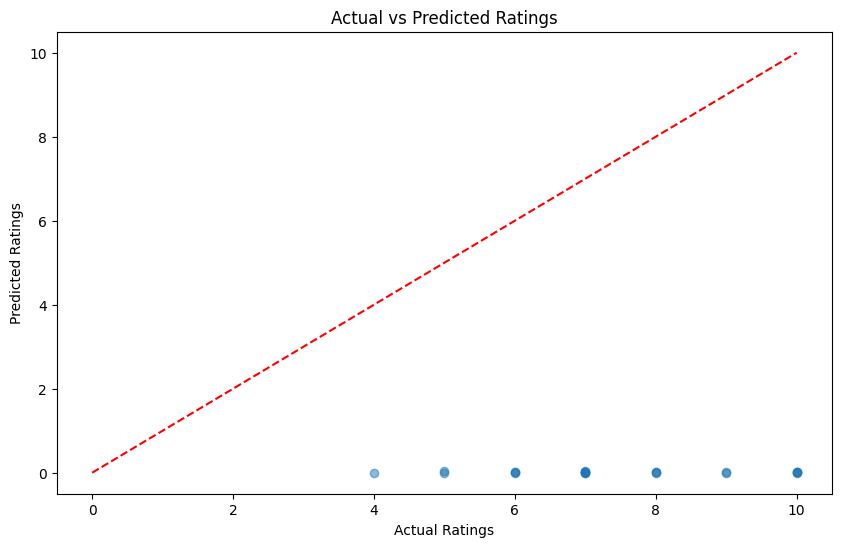

In [ ]:
import matplotlib.pyplot as plt

# Function to plot the actual vs predicted ratings for a subset of users
def plot_actual_vs_predicted(test_user_item_rating, model_knn, num_users=10):
    test_users = test_user_item_rating.index.tolist()
    all_predictions = []
    actual_ratings_list = []

    for user_id in test_users[:num_users]:  # Limiting to a subset of users for visualization
        user_loc = test_user_item_rating.index.get_loc(user_id)
        distances, indices = model_knn.kneighbors(test_matrix[user_loc], n_neighbors=6)  # 5 recommendations + 1

        similar_users = indices.flatten()[1:]  # Skip the first user (itself)
        user_ratings = test_user_item_rating.iloc[user_loc]

        predicted_ratings = []
        for index in similar_users:
            if index < len(test_user_item_rating):
                similar_user_ratings = test_user_item_rating.iloc[index]
                common_books = user_ratings.index.intersection(similar_user_ratings.index)
                if len(common_books) > 0:
                    predicted_ratings.extend(similar_user_ratings[common_books].values)

        if predicted_ratings:
            all_predictions.append(np.mean(predicted_ratings))
        else:
            all_predictions.append(0)  # Handle cases where no predictions are available

        # Append actual ratings
        actual_ratings_list.append(user_ratings.values)

    # Flatten lists
    actual_ratings = np.array([item for sublist in actual_ratings_list for item in sublist])
    predicted_ratings = np.array(all_predictions * len(test_user_item_rating.columns))

    # Filter out zero predictions if any (since they indicate no predictions were made)
    non_zero_indices = actual_ratings != 0
    non_zero_actual = actual_ratings[non_zero_indices]
    non_zero_predicted = predicted_ratings[non_zero_indices]

    # Plotting the actual vs predicted ratings
    plt.figure(figsize=(10, 6))
    plt.scatter(non_zero_actual, non_zero_predicted, alpha=0.5)
    plt.plot([0, 10], [0, 10], 'r--')  # Identity line for reference
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Actual vs Predicted Ratings')
    plt.show()

# Call the plotting function
plot_actual_vs_predicted(test_user_item_rating, model_knn)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

import pickle

# Save the model
with open('book_recommendation_knn_model.pkl', 'wb') as file:
    pickle.dump(model_knn, file)


In [ ]:
import os

# Get the current working directory
cwd = os.getcwd()
print(f"The model is saved in the following directory: {cwd}")

The model is saved in the following directory: /content
